# Lab 5

The goal of this lab is to test algorithms for Agglomerative Clustering and Hierarchical Classification. The former algorithm uses a "bottom up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy defined by some distance metric. The latter algorithm tries instead to deduce which classes are more meaningful, in order to produce a hierarchy which can be easily plotted as a Decision Tree.

In [1]:
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

def standardize (x):
    return (x-x.mean())/x.std()

def square_distance (x, xk):
    return np.linalg.norm(x - xk)**2

def cov_matrix (x):
    n = float(len(x))
    return 1.0/n * x.T.dot(x)

def load_data ():
    
    df = pd.read_csv("../Data/chronic_kidney_disease.csv", skipinitialspace=True, header=None)
    df = df.replace({"?": np.NaN})
    df = df.replace({"\t?": np.NaN})
    df = df.replace({"\tyes": "yes"})
    df = df.replace({"\tno": "no"})
    df = df.replace({"ckd\t": "no"})
    for col in df:
        df[col] = df[col].fillna(df[col].mode().values[0])
    keylist = ["normal","abnormal","present","notpresent","yes","no","good","poor","ckd","notckd"]
    keymap = [0,1,0,1,0,1,0,1,1,0]
    df = df.replace(keylist, keymap)
    for col in [5,6,7,8,18,21,22,23]:
        df[(-df[col].isin([0,1]))] = df[col].mode().values[0]
        
    return df

df = load_data().astype(float)
true = df[24]
df = df.drop(24, axis=1)

A common way to visualize Hierarchical Clustering is represented by the dendrogram, a binary tree which we can cut at the depth we prefer to change the number of clusters. In the next cell, the scipy functions linkage and dendrogram are used respectively to compute the linkage matrix and produce visualization of dendrogram in complete format and compressed versions.

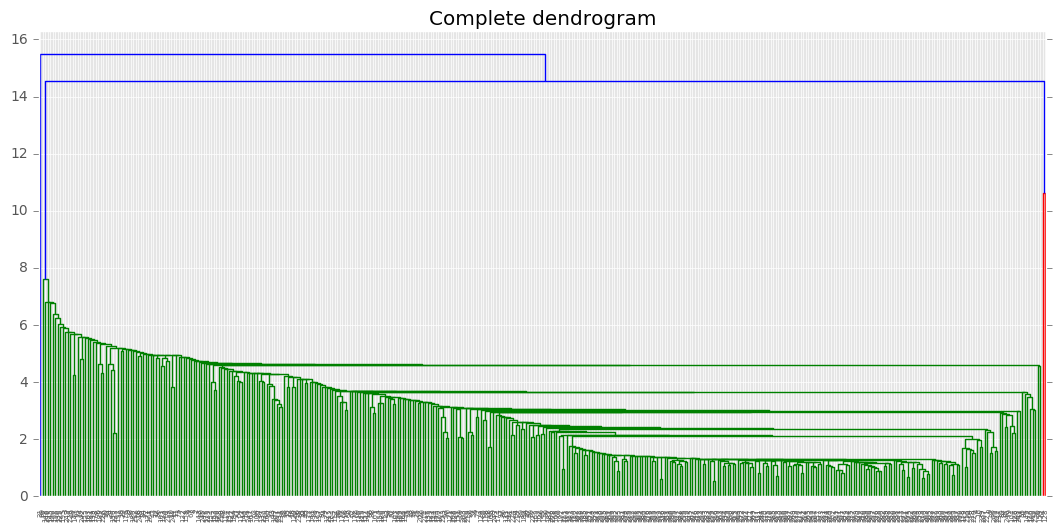

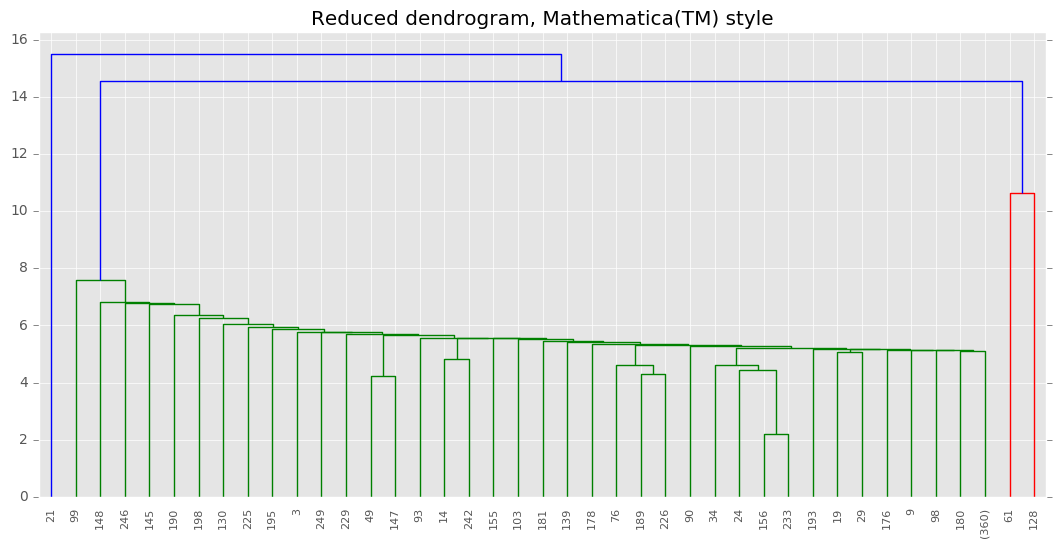

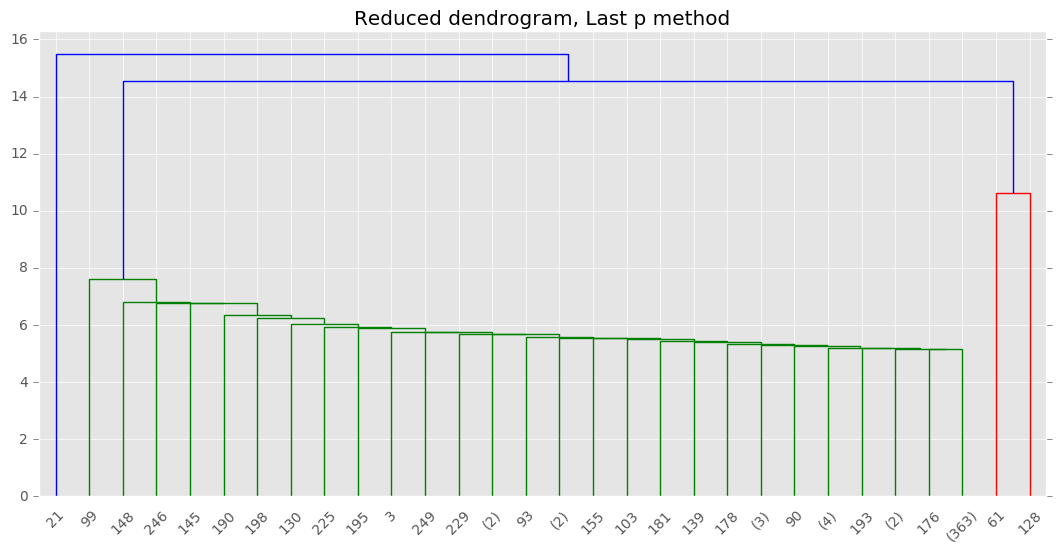

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(df.apply(standardize).values, 
            method='single', 
            metric='euclidean')

plt.figure(figsize=(13, 6))
plt.title("Complete dendrogram")
d1 = dendrogram(Z)

plt.figure(figsize=(13, 6))
plt.title("Reduced dendrogram, Mathematica(TM) style")
d2 = dendrogram(Z, truncate_mode="mtica")

plt.figure(figsize=(13, 6))
plt.title("Reduced dendrogram, Last p method")
d3 = dendrogram(Z, truncate_mode="lastp")

In the next cell, an Agglomerative Clustering is fitted with 2 clusters using the open source library sklearn, and its performances are tested using cross-validation and silhouette score. 

In [3]:
from sklearn import cluster
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import ShuffleSplit

model = cluster.AgglomerativeClustering(n_clusters=2)
clusters = model.fit_predict(df.values)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
print metrics.silhouette_score(df, model.labels_, metric='sqeuclidean')

0.693731339974


Before fitting the Classification Tree, a PCA is performed, because this method is sensible to collinearity in features. Then the DecisionTreeClassifier class from sklearn is used to fit the model and accuracy scores of cross-validation are shown. Finally, the tree is shown as an image.
The Gini impurity, a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset, is shown in the leaves of the tree.

In [4]:
def get_PCA (x):
                    
    Rx = cov_matrix(x)
    eigvals, U = np.linalg.eig(Rx)
    A = np.diag(eigvals)
    z = x.dot(U).dot(np.linalg.inv(A))
    
    return z

df = df.apply(standardize)
#df = get_PCA(df.apply(standardize))

clf = tree.DecisionTreeClassifier()
clf = clf.fit(df.values, true)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(clf, df, true, cv=cv)
print scores

predicted = cross_val_predict(clf, df, true, cv=10)
print metrics.accuracy_score(true, predicted)

[ 0.95    1.      0.975   0.9125  0.975   1.      0.975   0.975   0.9625
  0.95  ]
0.9625


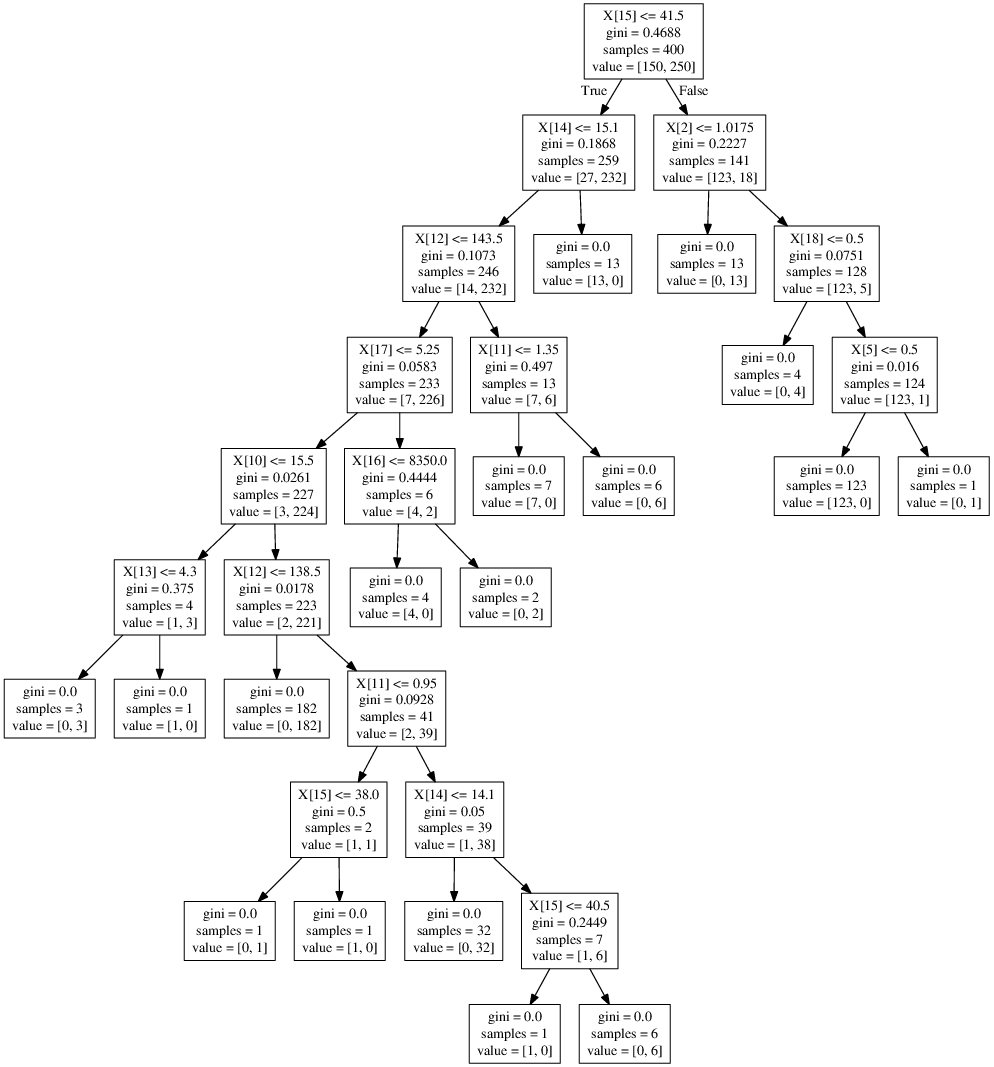

In [5]:
from IPython.display import Image
Image(filename='clf_tree.png')